# Linear regression with sklearn API

Setup:

1. Dataset: California housing
2. Linear regression API: `LinearRegression`
3. Training: `fit`(normal equation) and `cross_validate`(normal equation with cross validation).
4. Evaluation: `score`($R^2$ Score) and `cross_val_score` with different scoring parameters.

We will study the model diagnosis with `LearningCurve` and learn how to examine the learned model or weight vector.

In [40]:
#Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import mean_squared_error

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [3]:
np.random.seed(306)
plt.style.use('seaborn')

We will use `ShuffleSplit` cross validation with:
* 10 folds (`n_splits`) and
* Set aside 20% examples as test examples(`test_size`) in each fold.

In [5]:
shuffle_split_cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

## **Step 1**: Load the dataset

In [7]:
features, labels = fetch_california_housing(as_frame=True, return_X_y=True)

print("shape of feature matrix: ", features.shape)
print("shape of label matrix: ", labels.shape)

shape of feature matrix:  (20640, 8)
shape of label matrix:  (20640,)


sanity check

In [8]:
assert(features.shape[0] == labels.shape[0])

## **Step 2**: Data exploration

[Done in seperate notebook](California_housing_dataset_exploration.ipynb)

## **Step 3**: Preprocessing and model building

### 3.1 Train test split

In [11]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=42)

print("# training samples: ", train_features.shape[0])
print("# training samples: ", test_features.shape[0])

# training samples:  15480
# training samples:  5160


Sanity checks

In [12]:
assert (train_features.shape[0] == train_labels.shape[0])
assert (test_features.shape[0] == test_labels.shape[0])

### 3.2 Pipeline: Preprocessing + Model

`Pipeline` object we are going to use have two components:
1. `StandardScaler`
2. `LinearRegression`

In [15]:
lin_reg_pipeline = Pipeline([("feature_scaling", StandardScaler( )),
                            ("lin_reg", LinearRegression())])

lin_reg_pipeline.fit(train_features, train_labels)

Pipeline(steps=[('feature_scaling', StandardScaler()),
                ('lin_reg', LinearRegression())])

Now that we have trained the model, let's check the learned/estimated weight vectors

In [17]:
print("Intercept (w_0):", lin_reg_pipeline[-1].intercept_) # intercept through intercept_
print("Weight vector (w_1,....., w_m):", lin_reg_pipeline[-1].coef_) # rest of the weights through weight_

Intercept (w_0): 2.0703489205426377
Weight vector (w_1,....., w_m): [ 0.85210815  0.12065533 -0.30210555  0.34860575 -0.00164465 -0.04116356
 -0.89314697 -0.86784046]


## **Step 4**: Model Evaluation

### `score`

* $R^2$ score 

In [18]:
#Evaluate model performance in the test set.add
test_score = lin_reg_pipeline.score(test_features, test_labels)
print("Model performance on test set: ", test_score)

train_score = lin_reg_pipeline.score(train_features, train_labels)
print("Model performance on train set: ", train_score)

Model performance on test set:  0.5910509795491352
Model performance on train set:  0.609873031052925


`r2` score is not high enough $=>$ underfitting

### Cross validated score(`cross_val_score`)

* Calculates `r2` on different folds through cross validation

In [20]:
lin_reg_score = cross_val_score(lin_reg_pipeline,
                                train_features,
                                train_labels,
                                scoring = 'neg_mean_squared_error',
                                cv = shuffle_split_cv)

#This will print 10 different scores, one for each score
print(lin_reg_score)

# We can take the mean and standard deviation of the score and report it.
print(f"\nScore of linear regression model on the test set: \n"
        f"{lin_reg_score.mean():.3f} +/- {lin_reg_score.std():.3f}")

[-0.50009976 -0.52183352 -0.55931218 -0.52110499 -0.56059203 -0.50510767
 -0.52386194 -0.54775518 -0.5007161  -0.54713448]

Score of linear regression model on the test set: 
-0.529 +/- 0.022


Other available 'scoring` parameters
* `explained_variance`
* `max_error`
* `neg_mean_absolute_error`
* `neg_root_mean_squared_error`
* `neg_mean_squared_log_error`
* `neg_median_absolute_error`
* `neg_mean_absolute_percentaage_error`
* `r2`

### Cross Validation

* `cross_validate` gives access to models trained in each fold along with some other statistics

In [21]:
lin_reg_cv_results = cross_validate(lin_reg_pipeline,
                                    train_features,
                                    train_labels,
                                    cv = shuffle_split_cv,
                                    scoring="neg_mean_squared_error",
                                    return_train_score=True,
                                    return_estimator=True)

In [22]:
lin_reg_cv_results

{'fit_time': array([0.01699948, 0.00999665, 0.00800085, 0.00799918, 0.00933242,
        0.00699949, 0.00798869, 0.00769305, 0.00799775, 0.00883651]),
 'score_time': array([0.00199914, 0.00199866, 0.00200057, 0.00100088, 0.00300717,
        0.00199842, 0.00200725, 0.00143361, 0.00101113, 0.00200868]),
 'estimator': [Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('feature_scaling', StandardScaler()),
                  ('lin_reg', LinearRegression())]),
  Pipeline(steps=[('featu

multiply these scores by -1 to convert them into errors

In [23]:
train_error = -1 * lin_reg_cv_results['train_score']
test_error = -1 * lin_reg_cv_results['test_score']

print(f"Mean squareed error of linear regression model on the train set:\n"
        f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

print(f"Mean squareed error of linear regression model on the test set:\n"
        f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squareed error of linear regression model on the train set:
0.519 +/- 0.006
Mean squareed error of linear regression model on the test set:
0.529 +/- 0.022


* The training and test errors are high, which is an indication of underfitting, which we will confirm by plotting the learnig curve.
* Test error has high variability across different folds compared to the training error.

### Effect of training set size on error 

In [30]:
# Function for visualisation

def plot_learning_curve(train_sizes, train_scores, test_scores):

    train_scores_mean = np.mean(-train_scores, axis=1)
    train_scores_std = np.std(-train_scores, axis=1)
    test_scores_mean = np.mean(-test_scores, axis=1)
    test_scores_std = np.std(-test_scores, axis=1)

    plt.fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha = 0.1,
            color = "r",)

    plt.fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha = 0.1,
            color = "g",)

    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    plt.xlabel("Training examples")
    plt.ylabel("MSE")
    plt.legend(loc="best")

Based on the scores calculated by `learning_curve` API, we plot the error and its standard deviation for different number of samples.

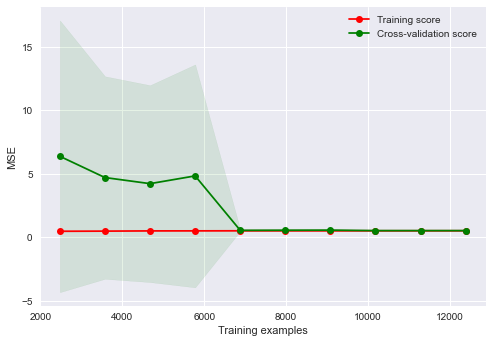

In [31]:
(train_sizes, train_scores, test_scores, fit_times, score_times) = learning_curve(lin_reg_pipeline,
                                                                                    train_features,
                                                                                    train_labels,
                                                                                    cv=shuffle_split_cv,
                                                                                    scoring='neg_mean_squared_error',
                                                                                    n_jobs=-1,
                                                                                    return_times=True,
                                                                                    train_sizes=np.linspace(0.2, 1.0, 10))

plot_learning_curve(train_sizes, train_scores, test_scores)

observations:

* Both curves have reached a plateau" They are close and fairly high.
* Few instances in the training set mean the model can fit them perfectly. But as more instances are added to the training set, it becomes impossible for the model to fit the training data perfectly.
* When the model is trained on very few instances, it is not able to generalize properly, hence the validation error is high.

These learning curves are typical of underfitting model

### Model Examination

Let's examine the weight vectors and how much variability exists between them across different cross-validated models

In [32]:
feature_names = train_features.columns
feature_names

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude'],
      dtype='object')

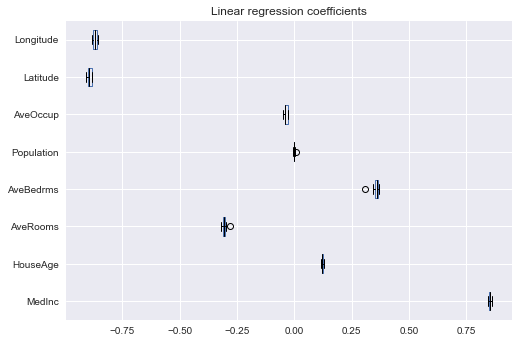

In [33]:
coefs = [est[-1].coef_ for est in lin_reg_cv_results["estimator"]]
weights_df = pd.DataFrame(coefs, columns=feature_names)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
weights_df.plot.box(color=color, vert=False)
_ = plt.title("Linear regression coefficients")

There is not much variability in weights learned by different models. It can also be seen from the std deviation

In [36]:
weights_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.852153,0.122770,-0.304384,0.353528,-0.001576,-0.037059,-0.894011,-0.869753
std,0.005763,0.004312,0.010998,0.018044,0.003254,0.008582,0.009975,0.009097
min,0.843517,0.117394,-0.318971,0.307474,-0.005787,-0.047584,-0.908058,-0.884206
25%,0.848871,0.119895,-0.310778,0.349715,-0.002688,-0.042486,-0.901411,-0.876542
50%,0.852711,0.121592,-0.305795,0.360139,-0.002063,-0.042325,-0.895370,-0.869631
75%,0.854743,0.125520,-0.302980,0.364646,-0.000350,-0.027562,-0.883967,-0.862110
max,0.861659,0.130560,-0.278426,0.367952,0.005297,-0.026331,-0.881884,-0.857844


### Selecting best model

In [37]:
best_model_index = np.argmin(test_error)
selected_model = lin_reg_cv_results['estimator'][best_model_index]

In [39]:
print("Intercept (w_0):", selected_model['lin_reg'].intercept_) # intercept through intercept_
print("Weight vector (w_1,....., w_m):", selected_model['lin_reg'].coef_) # rest of the weights through weight_

Intercept (w_0): 2.0779898917958657
Weight vector (w_1,....., w_m): [ 8.44324888e-01  1.18463901e-01 -3.04619574e-01  3.56620503e-01
  1.74458509e-04 -4.23964612e-02 -8.96045642e-01 -8.68906479e-01]


### Model performance


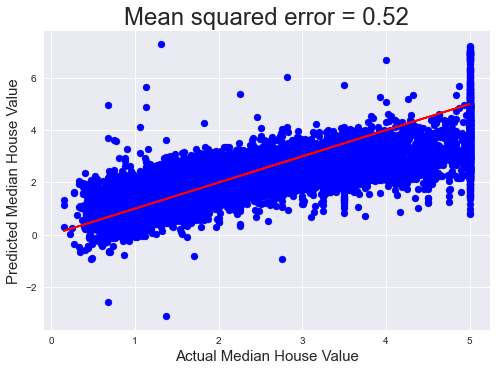

In [43]:
cv_predictions = cross_val_predict(lin_reg_pipeline, train_features, train_labels)

mse_cv = mean_squared_error(train_labels, cv_predictions)

plt.scatter(train_labels, cv_predictions, color='blue')
plt.plot(train_labels, train_labels, 'r-')
plt.title(f"Mean squared error = {mse_cv:.2f}", size=24)
plt.xlabel("Actual Median House Value", size=15)
plt.ylabel("Predicted Median House Value", size=15)
plt.show()

At this stage, we should perform error analysis and check where the predictions are going wrong. We can revisit feature construction, preprocessing and model stages and make the necessary course correction to get better performance.

## STEP 5: Predictions

In [44]:
test_predictions_cv = selected_model.predict(test_features)
test_predictions_cv[:5]

array([0.73548515, 1.7725621 , 2.70011199, 2.83716602, 2.60743151])

We can also obtain predictions using initial model that we built without cross validation

In [45]:
test_predictions = lin_reg_pipeline.predict(test_features)
test_predictions[:5]

array([0.72412832, 1.76677807, 2.71151581, 2.83601179, 2.603755  ])

## STEP 6: Report model performance


In [47]:
score_cv = selected_model.score(test_features, test_labels)
score = lin_reg_pipeline.score(test_features, test_labels)

print("R2 score for the best model obtained via cross validation: ", score_cv)
print("R2 score for the model without cross validation: ", score)

R2 score for the best model obtained via cross validation:  0.5923577635319088
R2 score for the model without cross validation:  0.5910509795491352


Cross validated models have slightly better results